In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr

In [88]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('066570', '2000-01-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close   Volume    Change
Date                                                     
2002-04-22  55509  63815  55509  62936  8151792       NaN
2002-04-23  60688  61372  57170  57464  5384435 -0.086945
2002-04-24  58147  59418  53065  55705  4659371 -0.030610
2002-04-25  53750  55118  50622  51209  3913730 -0.080711
2002-04-26  50622  54727  49156  53555  4176615  0.045812
...           ...    ...    ...    ...      ...       ...
2024-01-15  95300  95600  94900  95100   288403  0.004224
2024-01-16  94700  95400  93700  94600   443988 -0.005258
2024-01-17  94000  94100  90700  91300   922101 -0.034884
2024-01-18  91100  92400  91100  91200   491278 -0.001095
2024-01-19  92200  92400  90900  91800   434237  0.006579

[5377 rows x 6 columns]>

In [128]:
df.info

<bound method DataFrame.info of                 Open      High       Low     Close    Volume    Change
Date                                                                  
2002-04-22  0.168839  0.207920  0.185347  0.217167  0.364920       NaN
2002-04-23  0.202603  0.192942  0.196439  0.182074  0.237844 -0.086945
2002-04-24  0.186037  0.180961  0.169026  0.170793  0.204549 -0.030610
2002-04-25  0.157371  0.154596  0.152712  0.141958  0.170310 -0.080711
2002-04-26  0.136979  0.152199  0.142922  0.157004  0.182381  0.045812
...              ...       ...       ...       ...       ...       ...
2024-01-15  0.428251  0.402806  0.448399  0.423444  0.003836  0.004224
2024-01-16  0.424339  0.401579  0.440386  0.420238  0.010980 -0.005258
2024-01-17  0.419776  0.393609  0.420352  0.399074  0.032935 -0.034884
2024-01-18  0.400870  0.383185  0.423023  0.398433  0.013152 -0.001095
2024-01-19  0.408041  0.383185  0.421687  0.402281  0.010533  0.006579

[5377 rows x 6 columns]>

In [131]:
df.iloc[4600]

Open      0.377400
High      0.358047
Low       0.390969
Close     0.371497
Volume    0.024620
Change   -0.005714
Name: 2020-11-26 00:00:00, dtype: float64

In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

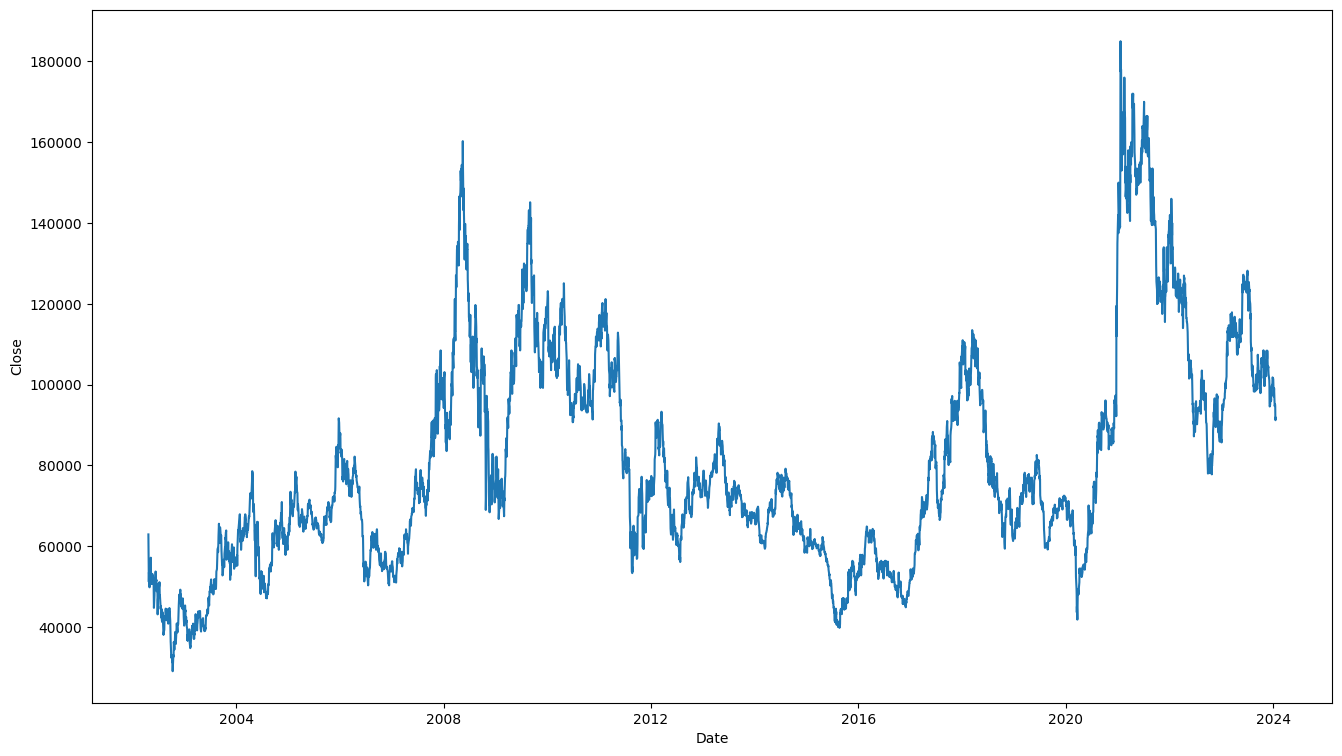

In [91]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [92]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [93]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

### 학습기간 : 앞 4000일

In [105]:
split = 4000
sequence_length = 5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 4000개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([4000, 5, 4]) torch.Size([4000, 1])
torch.Size([1372, 5, 4]) torch.Size([1372, 1])


In [106]:
x_train_seq

tensor([[[0.1688, 0.2079, 0.1853, 0.3649],
         [0.2026, 0.1929, 0.1964, 0.2378],
         [0.1860, 0.1810, 0.1690, 0.2045],
         [0.1574, 0.1546, 0.1527, 0.1703],
         [0.1370, 0.1522, 0.1429, 0.1824]],

        [[0.2026, 0.1929, 0.1964, 0.2378],
         [0.1860, 0.1810, 0.1690, 0.2045],
         [0.1574, 0.1546, 0.1527, 0.1703],
         [0.1370, 0.1522, 0.1429, 0.1824],
         [0.1338, 0.1366, 0.1495, 0.0820]],

        [[0.1860, 0.1810, 0.1690, 0.2045],
         [0.1574, 0.1546, 0.1527, 0.1703],
         [0.1370, 0.1522, 0.1429, 0.1824],
         [0.1338, 0.1366, 0.1495, 0.0820],
         [0.1383, 0.1306, 0.1423, 0.0815]],

        ...,

        [[0.4002, 0.3832, 0.4057, 0.0258],
         [0.3820, 0.3679, 0.3830, 0.0371],
         [0.3618, 0.3525, 0.3823, 0.0202],
         [0.3696, 0.3513, 0.3623, 0.0547],
         [0.3370, 0.3262, 0.3562, 0.0251]],

        [[0.3820, 0.3679, 0.3830, 0.0371],
         [0.3618, 0.3525, 0.3823, 0.0202],
         [0.3696, 0.3513, 0.3623

In [107]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

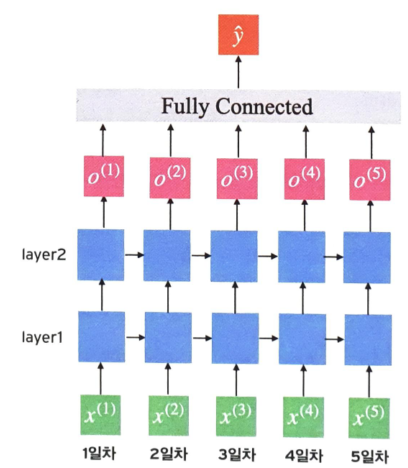

In [108]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [109]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [110]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [111]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [112]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0079
[epoch : 10] loss: 0.0003
[epoch : 20] loss: 0.0002
[epoch : 30] loss: 0.0002
[epoch : 40] loss: 0.0002


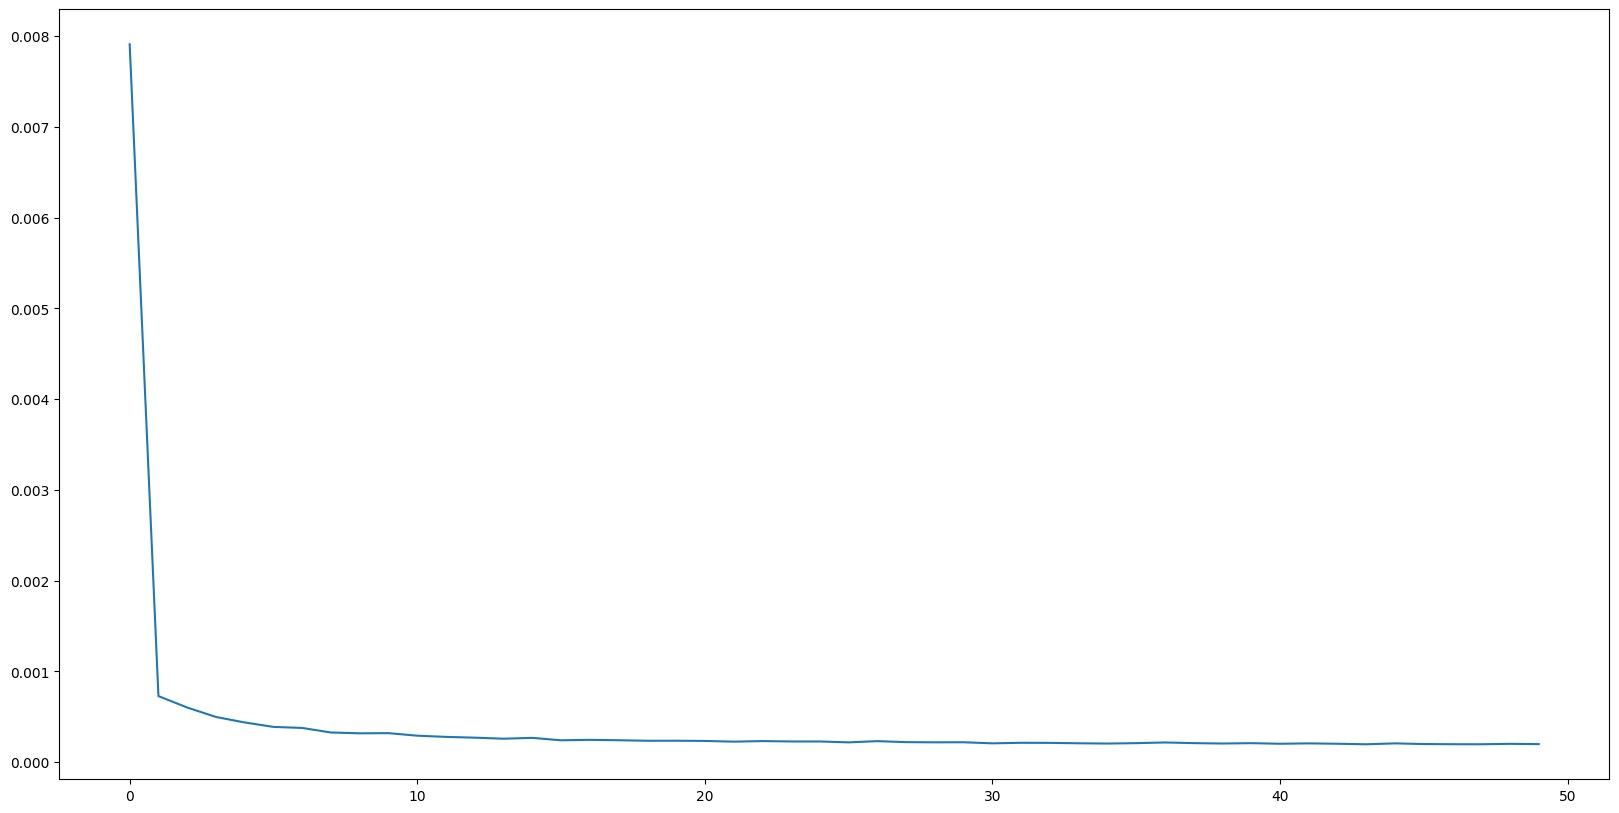

In [113]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [114]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

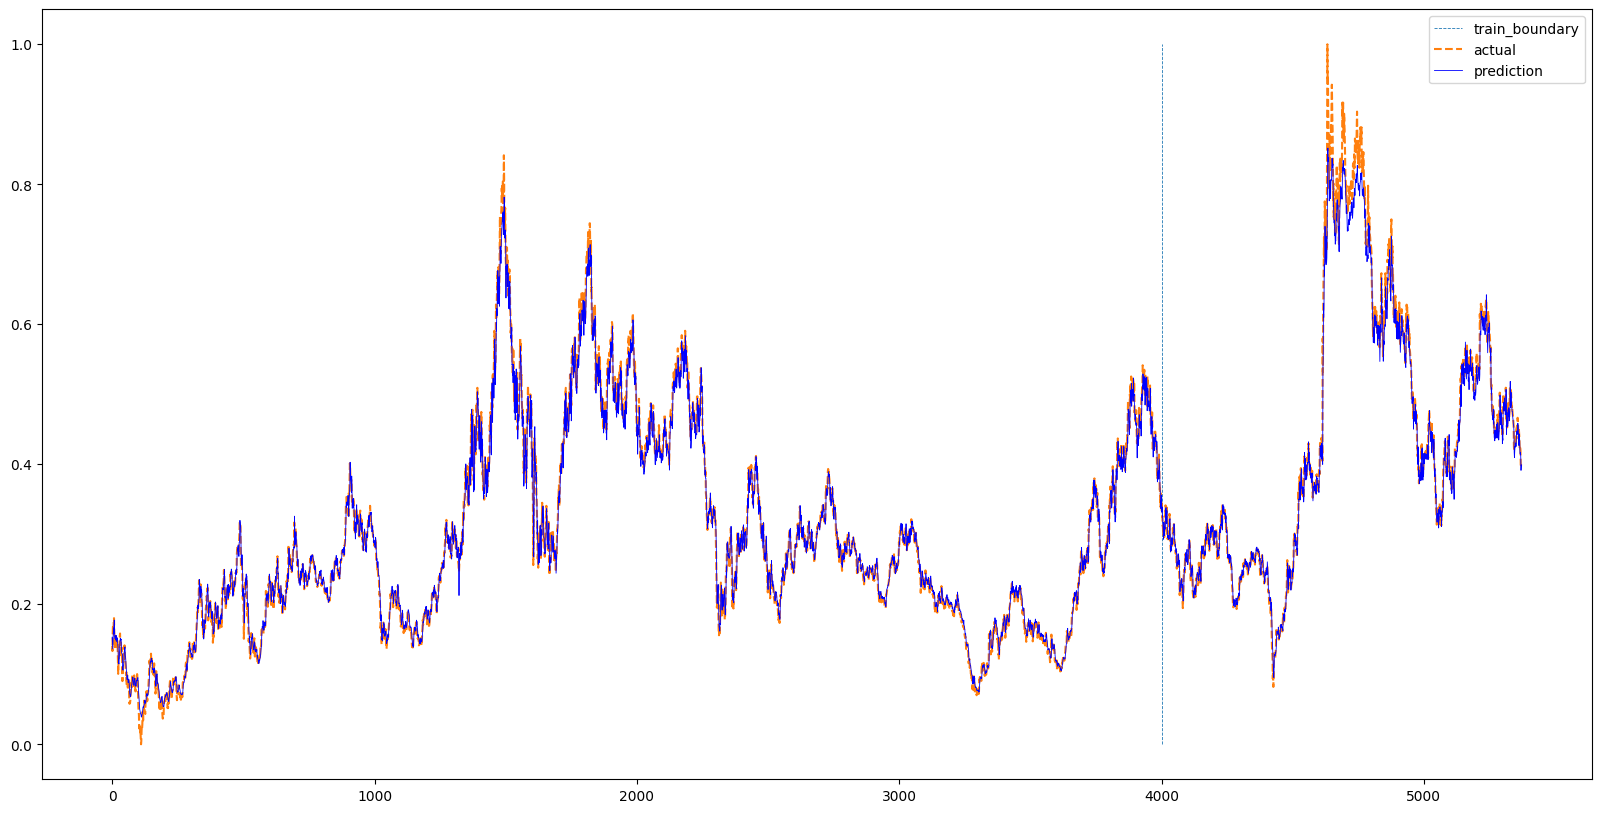

In [115]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

### Prediction이 잘 되는 이유 : 모델이 예측한 예측값을 가지고 다음 시점을 예측하는 것이 아닌, GT가 계속 주어지는 상황에서 다음날만 예측하고 있음.
-> 5일 동안의 값이 주어졌을 때, 다음 날 하루의 값에 대해서 평가가 진행되어야 할 것 같음.

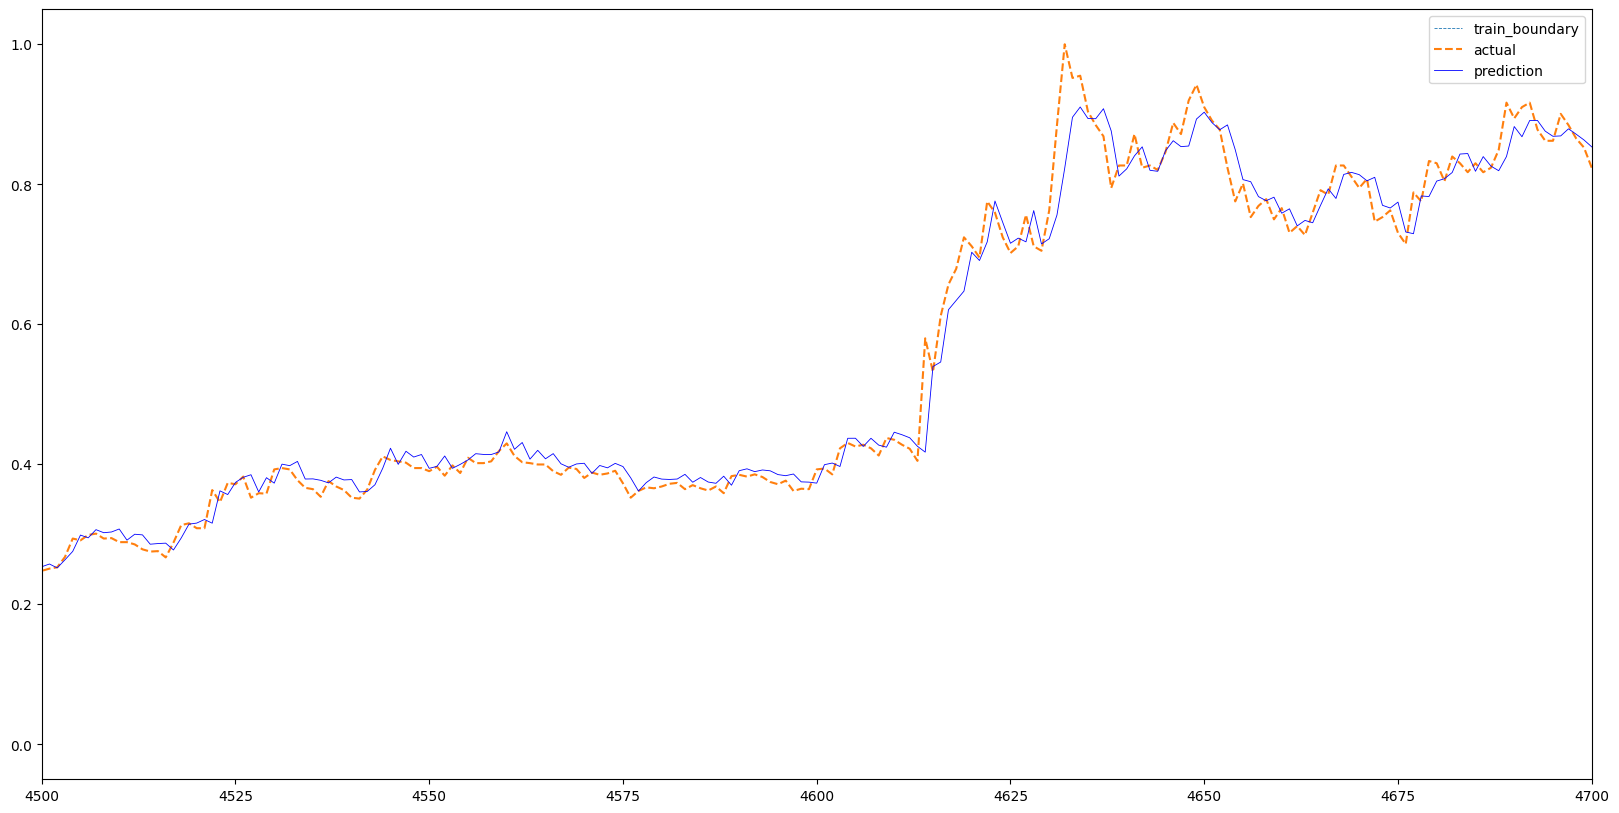

In [133]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.xlim([4500, 4700])
plt.show()

### 주가가 급등하는 구간을 확대해 보았을 때, Prediction이 모두 GT보다 하루씩 밀리는 것을 확인할 수 있음.

# LSTM
## 모델구축

In [116]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [117]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [118]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [119]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [120]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0032
[epoch: 10] loss: 0.0003
[epoch: 20] loss: 0.0002
[epoch: 30] loss: 0.0002
[epoch: 40] loss: 0.0002


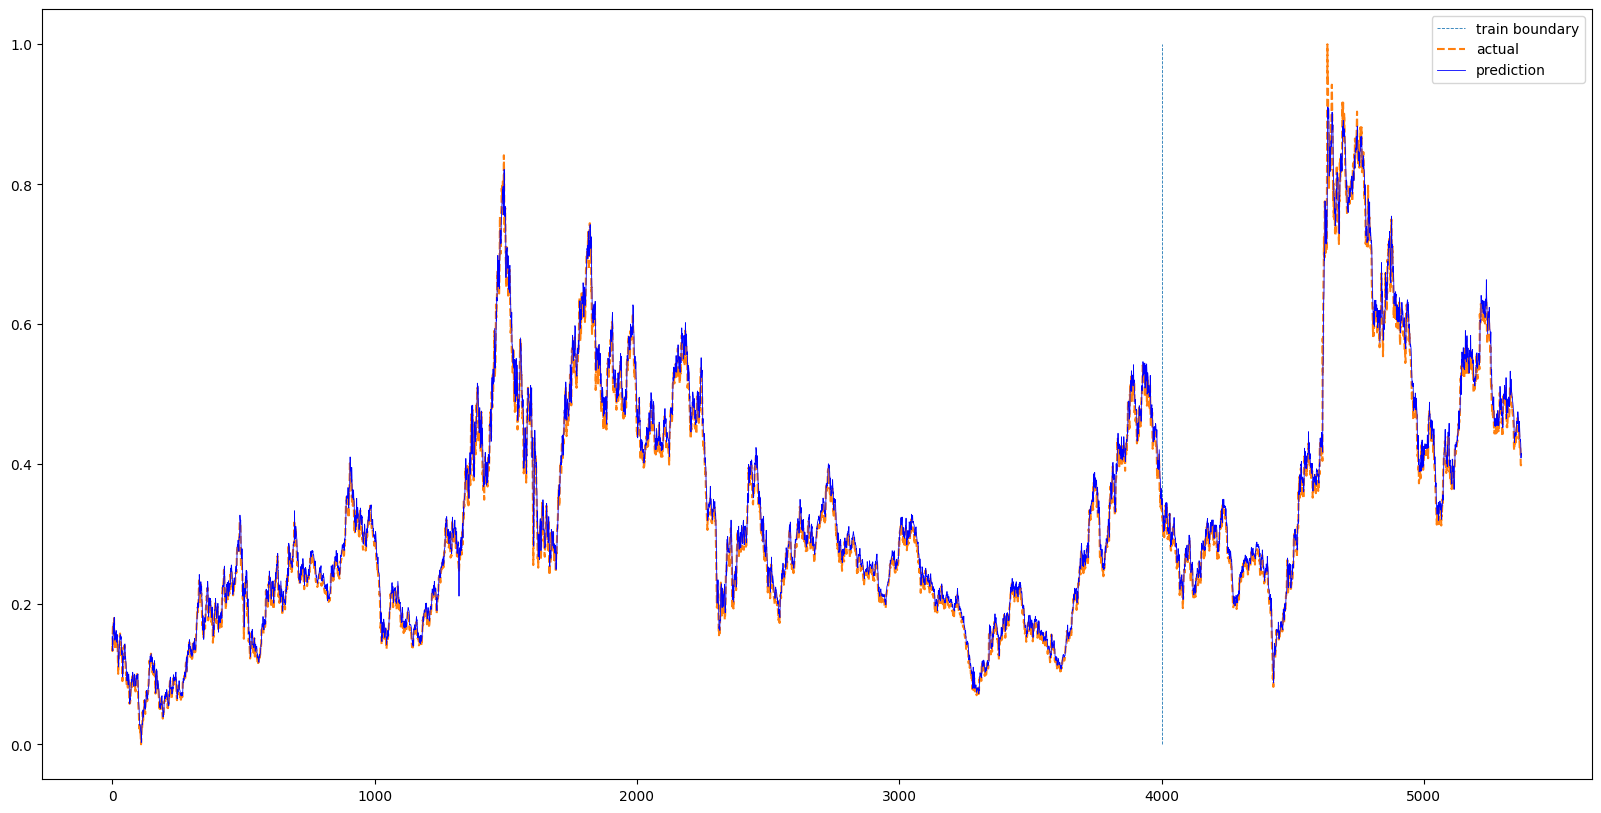

In [121]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()